# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Load Data

In [33]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv")
      .drop(['CustomerId', 'RowNumber', 'Surname','Exited'], axis=1)
      )
print(df.shape)
df.head(3)


(10000, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57


# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [34]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


## Principal Component Analysis (PCA)

In [35]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(10000, 10) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 10 components explain 100.0% of the data 



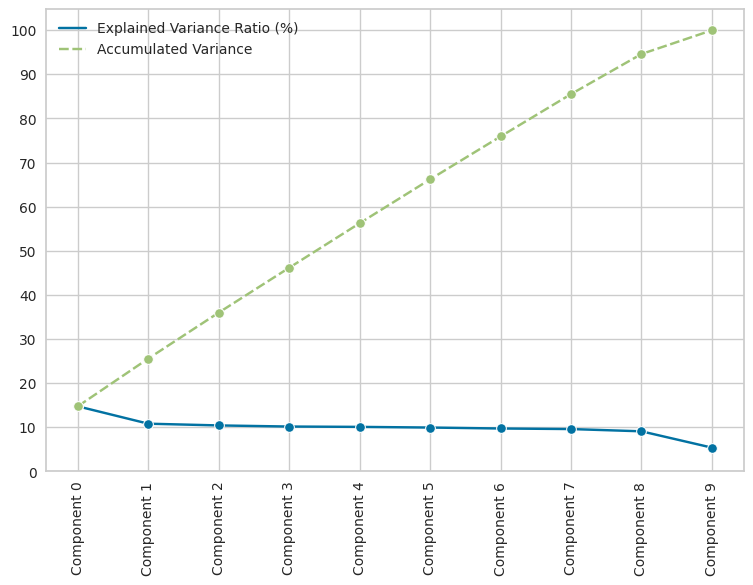

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 6 components explain 66.2% of the data 



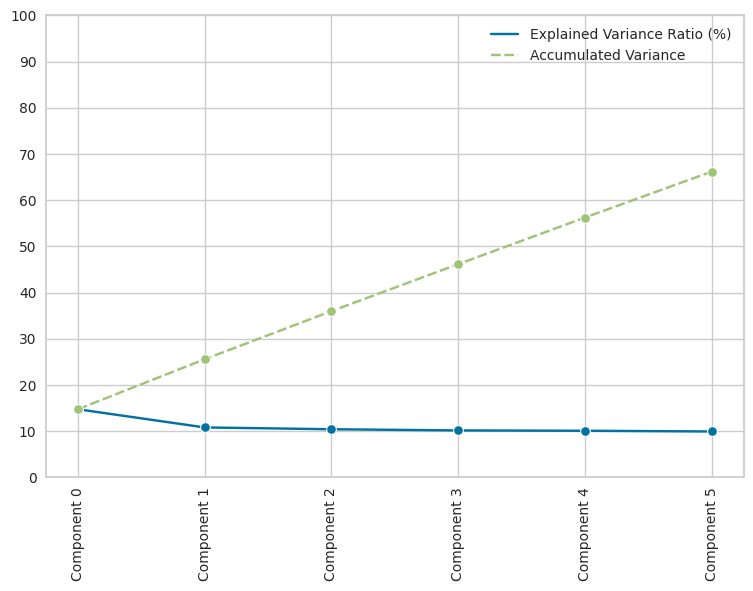

In [41]:
pca_components_analysis(df_pca=df_pca,n_components=6)

In [42]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 7
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

In [43]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(10000, 7) 
 <class 'numpy.ndarray'>


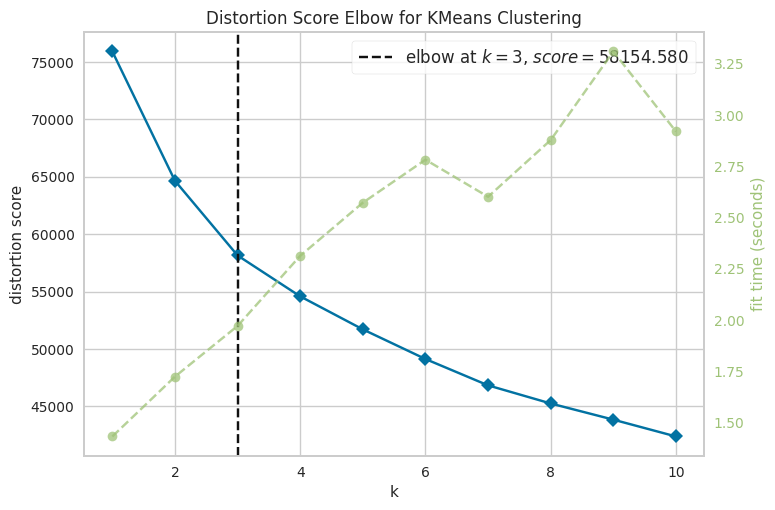

In [44]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) # 11 is not inclusive, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


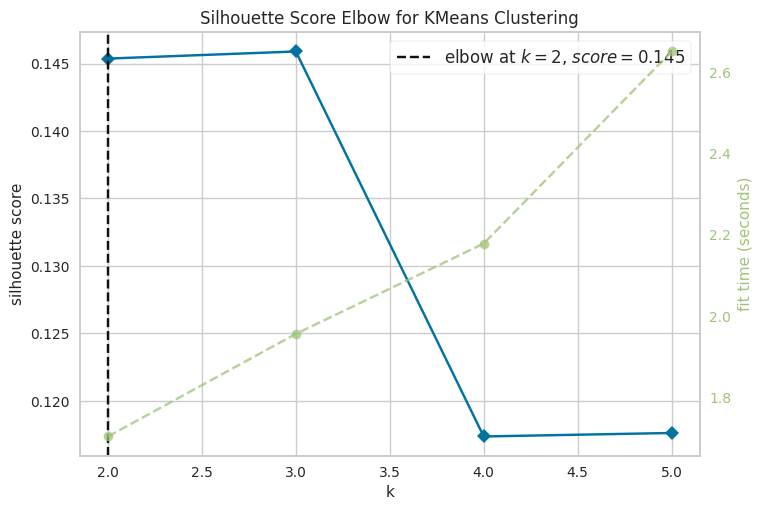



=== Silhouette plot for 2 Clusters ===


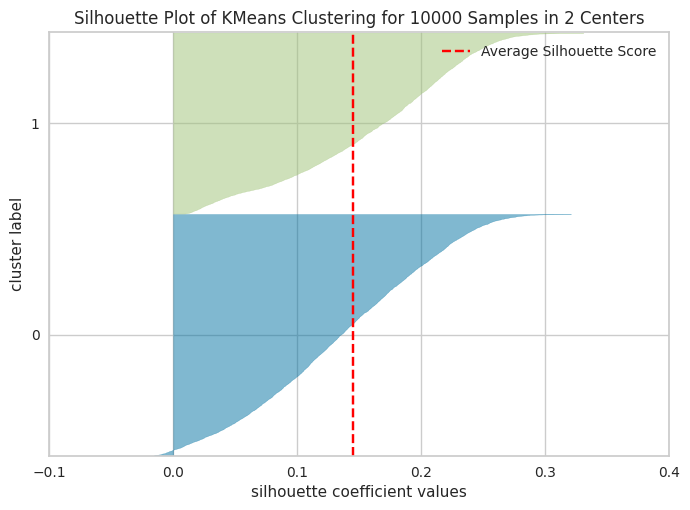



=== Silhouette plot for 3 Clusters ===


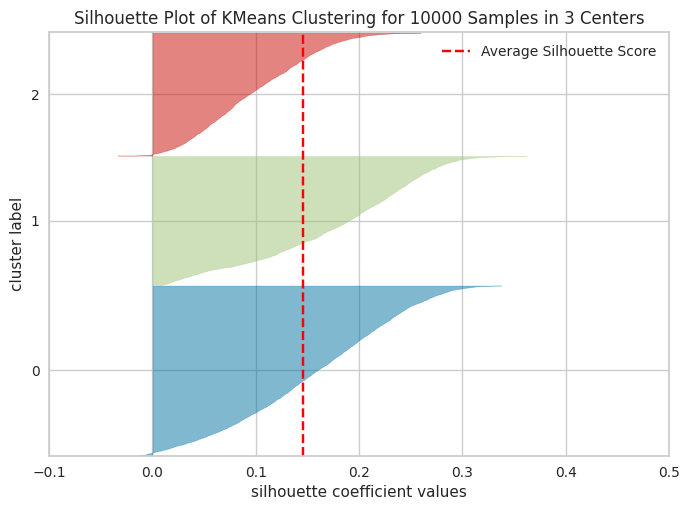



=== Silhouette plot for 4 Clusters ===


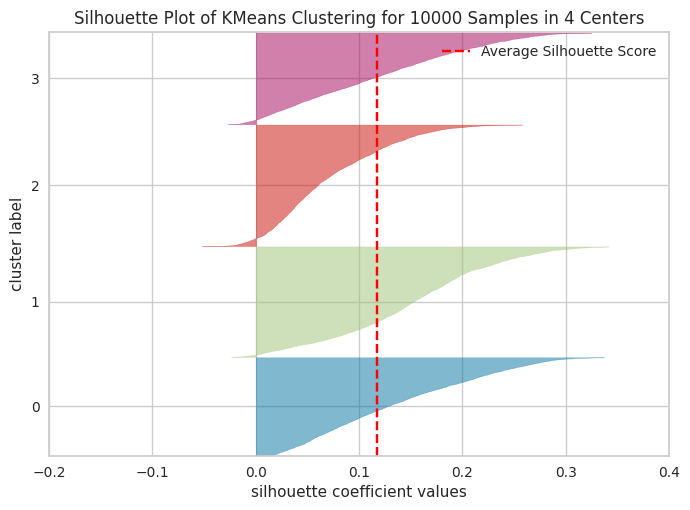



=== Silhouette plot for 5 Clusters ===


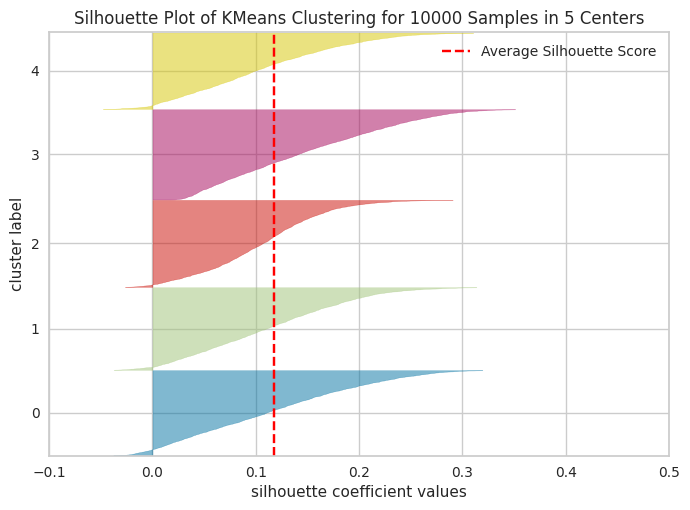

In [45]:
from yellowbrick.cluster import SilhouetteVisualizer

# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


In [52]:
def PipelineCluster():
    pipeline_base = Pipeline([
           ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
         
        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=6, random_state=0)),

        # we update n_clusters to 3
        ("model", KMeans(n_clusters=3, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=6, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Fit Cluster Pipeline

Quick recap of our data for training cluster pipeline

In [53]:
X = df.copy()
print(X.shape)
X.head(3)

(10000, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57


Fit Cluster pipeline

In [54]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Tenure',
                                                     'Balance', 'NumOfProducts',
                                                     'HasCrCard',
                                                

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [55]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Clusters
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,0


* Clusters frequencies 
   Clusters
0      0.37
1      0.33
2      0.31 




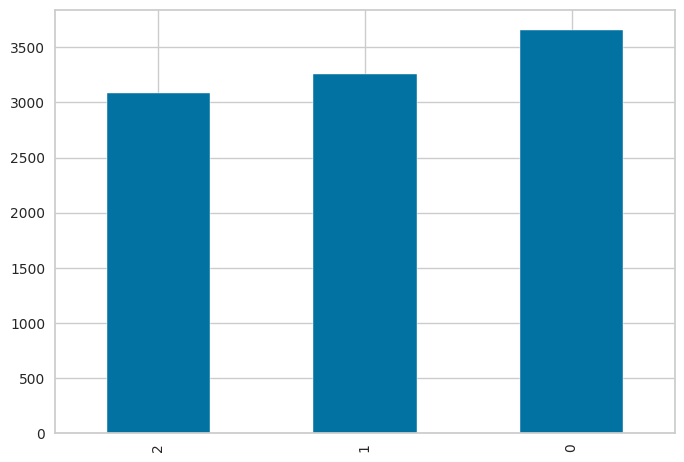

In [56]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

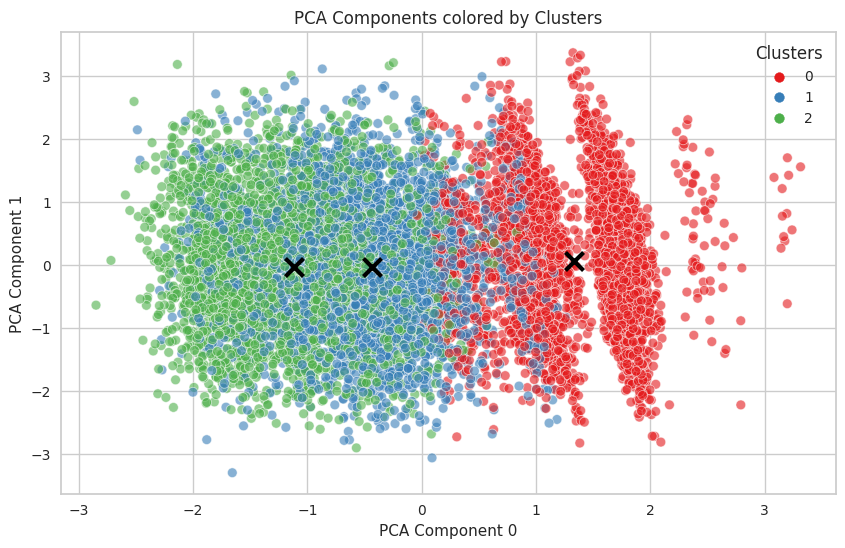

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()


We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [58]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       0
1       1
2       0
3       0
4       2
       ..
9995    0
9996    1
9997    0
9998    2
9999    1
Name: Clusters, Length: 10000, dtype: int32

## Fit a classifier, where the target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [63]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Clusters
0,619,France,Female,42,2,0.00,1,1,1,101348.88,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,0


Split Train and Test sets

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(8000, 10) (2000, 10)


Create classifier pipeline steps

In [65]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.ensemble import GradientBoostingClassifier


def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the classifier to the training data

In [66]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Tenure',
                                                     'Balance', 'NumOfProducts',
                                                     'HasCrCard',
                                                

## Evaluate classifier performance on Train and Test Sets

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2953
           1       0.86      0.87      0.87      2618
           2       0.87      0.88      0.87      2429

    accuracy                           0.91      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.91      0.91      0.91      8000



In [68]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       703
           1       0.84      0.85      0.84       639
           2       0.87      0.88      0.87       658

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



## Assess the most important Features that define a cluster

* These are the 4 most important features in descending order. The model was trained on them: 
['Balance', 'Geography', 'NumOfProducts', 'Gender'] 



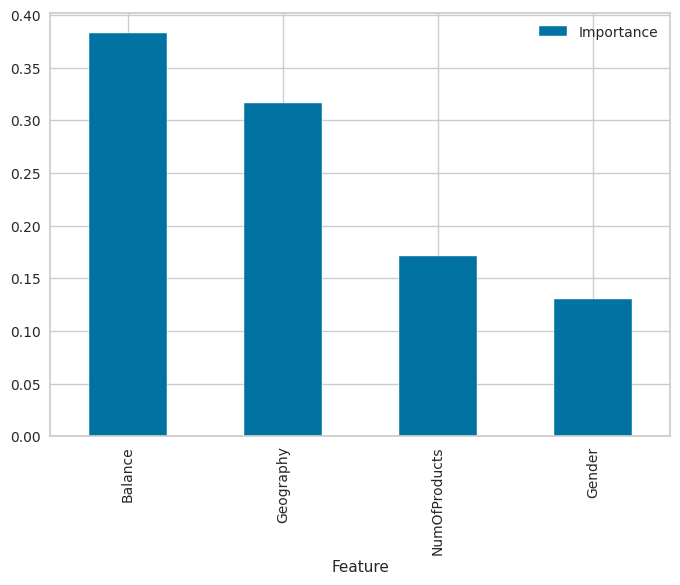

In [69]:
# after data cleaning and feature engineering, the feature space changes

# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We will store the best_features to use at a later stage.

In [70]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['Balance', 'Geography', 'NumOfProducts', 'Gender']

## Cluster Analysis

Load function that plots a table with description for all Clusters

In [71]:

def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [72]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='colab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='colab')


Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.


In [73]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(5)

(10000, 5)


,Balance,Geography,NumOfProducts,Gender,Clusters
0,0.00,France,1,Female,0
1,83807.86,Spain,1,Female,1
2,159660.80,France,3,Female,0
3,0.00,France,2,Female,0
4,125510.82,Spain,1,Female,2


We want also to analyse Churn levels.

In [74]:
df_churn = pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv").filter(['Exited'])
df_churn['Exited'] = df_churn['Exited'].astype('object')
df_churn.head(5)

,Exited
0,1
1,0
2,1
3,0
4,0


### Cluster profile based on the best features

In [75]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_225657/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_225657/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_225657/3568331369.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,Balance,Geography,NumOfProducts,Gender,Exited
Cluster,,,,,
0,0.0 -- 0.0,"'France': 71% , 'Spain': 29% , 'Germany': 0%",2.0 -- 2.0,"'Female': 53% , 'Male': 47%","'0': 86% , '1': 14%"
1,87213.0 -- 136556.0,"'France': 65% , 'Spain': 25% , 'Germany': 10%",1.0 -- 1.0,"'Male': 79% , 'Female': 21%","'0': 83% , '1': 17%"
2,103516.0 -- 141783.0,"'Germany': 71% , 'Spain': 19% , 'France': 10%",1.0 -- 2.0,"'Female': 62% , 'Male': 38%","'0': 69% , '1': 31%"


### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [77]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Exited')

Clusters distribution across Exited levels


Relative Percentage (%) of Exited in each cluster


# Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [78]:
best_features_pipeline_all_variables

['Balance', 'Geography', 'NumOfProducts', 'Gender']

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!
* The **gain** is that in real-time (which is the major purpose of Machine Learning) you will need fewer variables for predicting clusters for your prospects.

## Subset data with the most relevant variables

In [79]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,Balance,Geography,NumOfProducts,Gender
0,0.00,France,1,Female
1,83807.86,Spain,1,Female
2,159660.80,France,3,Female


## Rewrite Cluster Pipeline

In [80]:
def PipelineCluster():
    pipeline_base = Pipeline([

        # we update the pipeline, considering only the most important variables from the previous pipeline
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender','Geography'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=3, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Apply Elbow Method and Silhouette analysis

In [81]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(10000, 4) 
 <class 'numpy.ndarray'>


Elbow Analysis

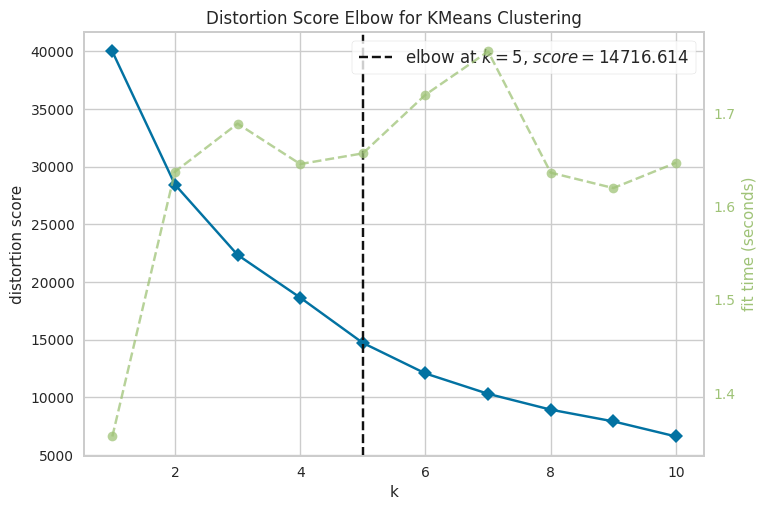

In [82]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



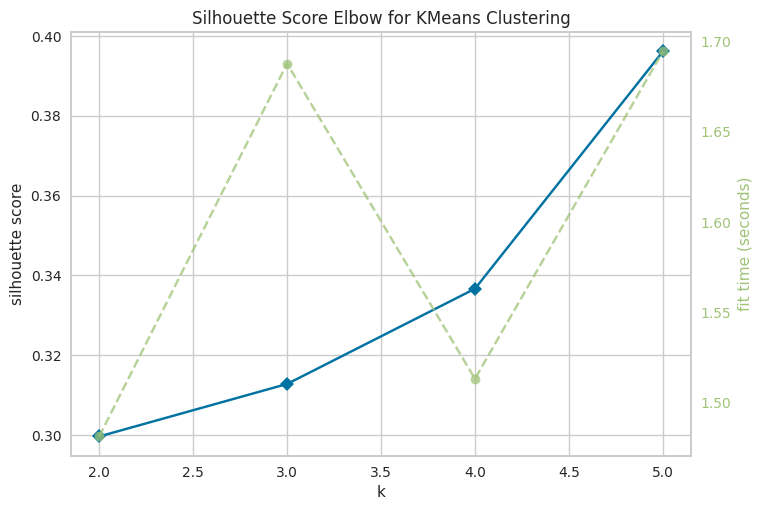



=== Silhouette plot for 2 Clusters ===


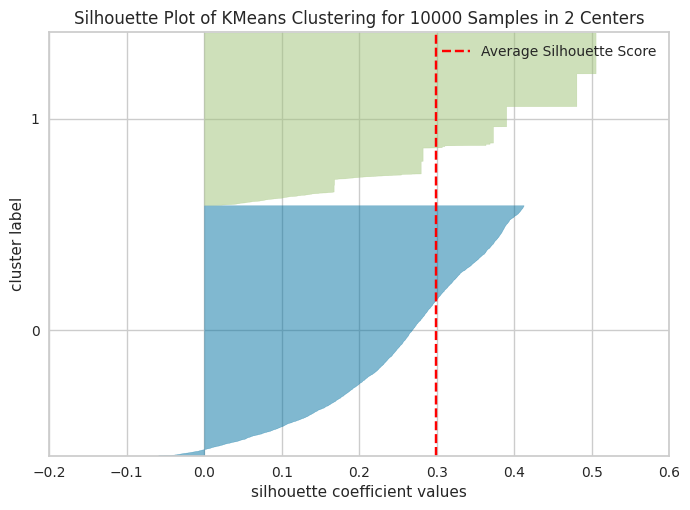



=== Silhouette plot for 3 Clusters ===


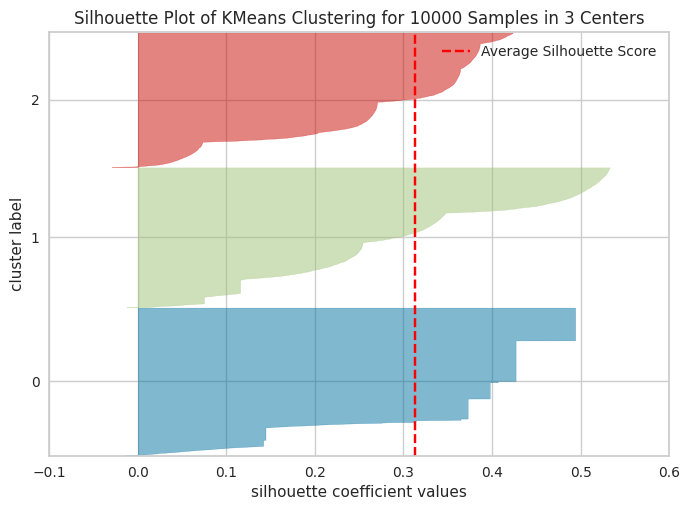



=== Silhouette plot for 4 Clusters ===


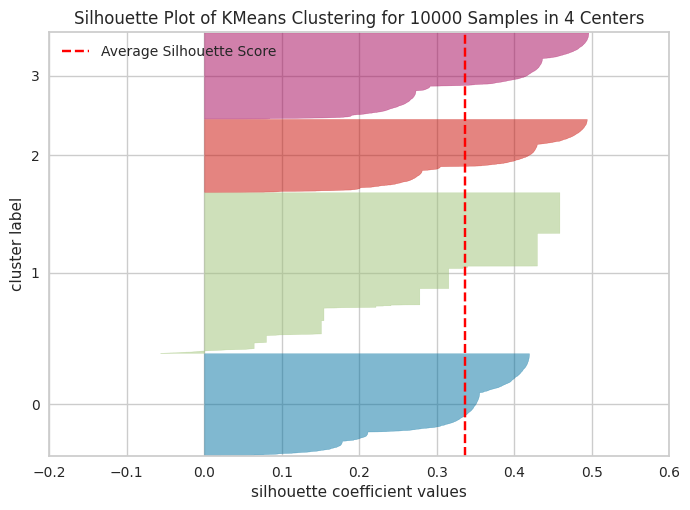



=== Silhouette plot for 5 Clusters ===


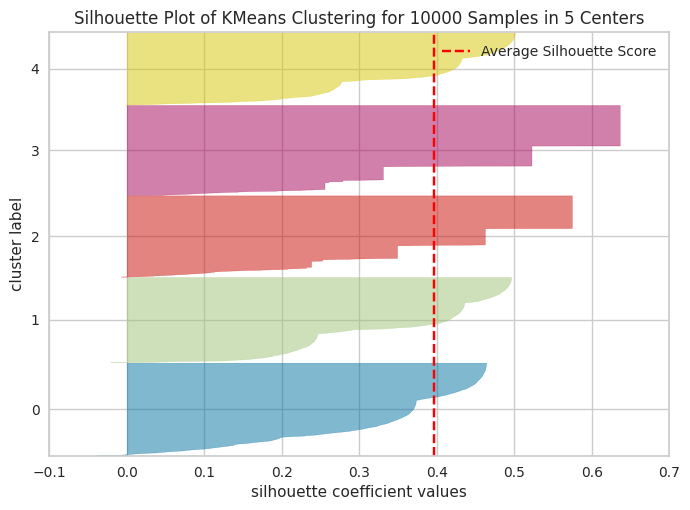

In [84]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


## Fit New Cluster Pipeline

We set X as our training set for the cluster. It is a copy of df_reduced

In [85]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(10000, 4)


,Balance,Geography,NumOfProducts,Gender
0,0.00,France,1,Female
1,83807.86,Spain,1,Female
2,159660.80,France,3,Female


Fit Cluster pipeline

In [86]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [87]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(10000, 5)


,Balance,Geography,NumOfProducts,Gender,Clusters
0,0.00,France,1,Female,0
1,83807.86,Spain,1,Female,2
2,159660.80,France,3,Female,0


* Clusters frequencies 
   Clusters
0      0.35
1      0.33
2      0.32 




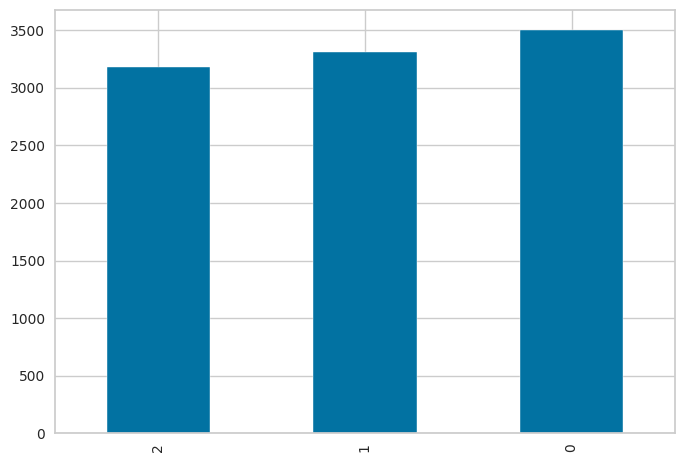

In [88]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [89]:
cluster_predictions_with_all_variables

0       0
1       1
2       0
3       0
4       2
       ..
9995    0
9996    1
9997    0
9998    2
9999    1
Name: Clusters, Length: 10000, dtype: int32

And these are the predictions from **current** cluster pipeline (trained with `['OnlineBackup', 'MonthlyCharges', 'PhoneService']`)

In [90]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

0       0
1       2
2       0
3       0
4       2
       ..
9995    0
9996    1
9997    0
9998    2
9999    1
Name: Clusters, Length: 10000, dtype: int32

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**

In [91]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

[[3425  213   18]
 [  39 2750  468]
 [  38  351 2698]]


## Fit a classifier, where the target is cluster predictions and features remaining variables

In [92]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(10000, 5)


,Balance,Geography,NumOfProducts,Gender,Clusters
0,0.00,France,1,Female,0
1,83807.86,Spain,1,Female,2
2,159660.80,France,3,Female,0


Split Train and Test sets

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(8000, 4) (2000, 4)


Rewrite pipeline to explain clusters

In [96]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [97]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

In [98]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2836
           1       1.00      1.00      1.00      2658
           2       1.00      1.00      1.00      2506

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [99]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       666
           1       1.00      1.00      1.00       656
           2       1.00      1.00      1.00       678

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



## Assess Most Important Features

* These are the 4 most important features in descending order. The model was trained on them: 
['Geography', 'Balance', 'NumOfProducts', 'Gender']


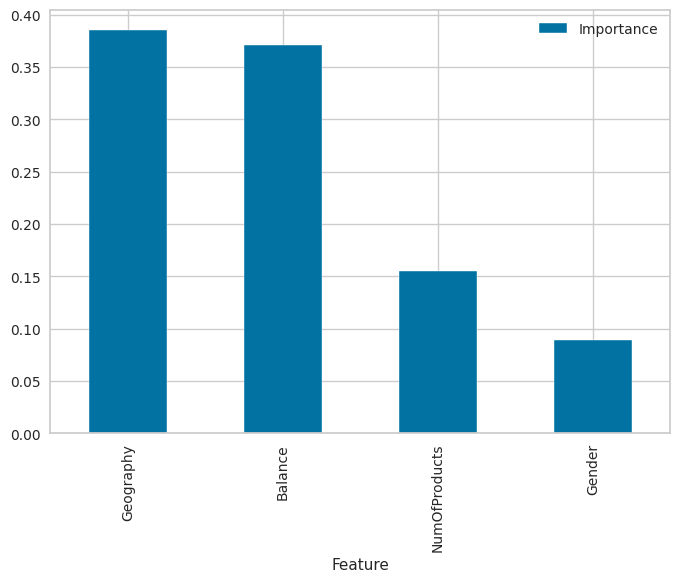

In [100]:
# since we don't have feature selection step in this pipeline, best_features is Xtrain columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.


In [101]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,Geography,Balance,NumOfProducts,Gender,Clusters
0,France,0.00,1,Female,0
1,Spain,83807.86,1,Female,2
2,France,159660.80,3,Female,0


We want also to analyse Churn levels

In [103]:
df_churn = pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv").filter(['Exited'])
df_churn['Exited'] = df_churn['Exited'].astype('object')
df_churn.head(3)

,Exited
0,1
1,0
2,1


### Cluster profile on most important features

In [104]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_225657/3568331369.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_225657/3568331369.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_225657/3568331369.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Geography,Balance,NumOfProducts,Gender,Exited
Cluster,,,,,
0,"'France': 69% , 'Spain': 31% , 'Germany': 0%",0.0 -- 0.0,2.0 -- 2.0,"'Female': 55% , 'Male': 45%","'0': 86% , '1': 14%"
1,"'France': 79% , 'Spain': 21%",86481.0 -- 138813.0,1.0 -- 1.0,"'Male': 72% , 'Female': 28%","'0': 82% , '1': 18%"
2,"'Germany': 79% , 'Spain': 21%",102689.0 -- 138651.0,1.0 -- 2.0,"'Female': 54% , 'Male': 46%","'0': 70% , '1': 30%"


### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [106]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Exited')

Clusters distribution across Exited levels


Relative Percentage (%) of Exited in each cluster


## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct an elbow method and silhouette analysis and check if the same number of clusters is suggested.
2. Fit a new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline.
3. Fit a classifier to explain cluster and check if performance on Train and Test sets is similar to the previous pipeline.
4. Check if the most important features for the classifier are the same from the previous pipeline.
5. Compare if the cluster profile from both pipelines is "equivalent".


In [59]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['OnlineBackup', 'PhoneService'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [107]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


## Cluster pipeline

In [108]:
pipeline_cluster

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [109]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

['outputs/ml_pipeline/cluster_analysis/v1/cluster_pipeline.pkl']

## Train Set

In [110]:
print(df_reduced.shape)
df_reduced.head(3)

(10000, 4)


,Balance,Geography,NumOfProducts,Gender
0,0.00,France,1,Female
1,83807.86,Spain,1,Female
2,159660.80,France,3,Female


In [111]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

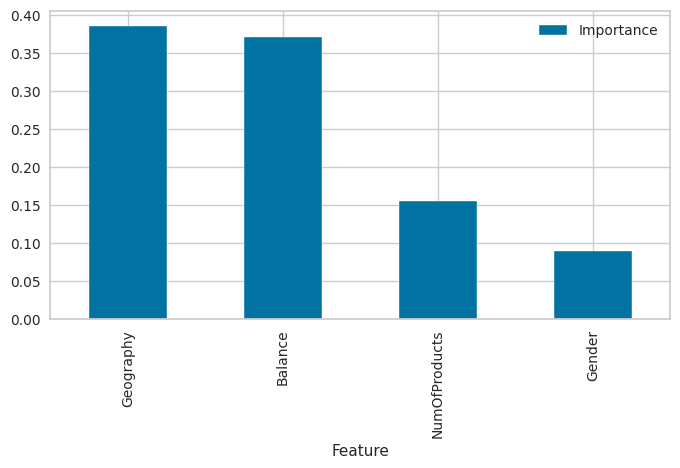

In [112]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

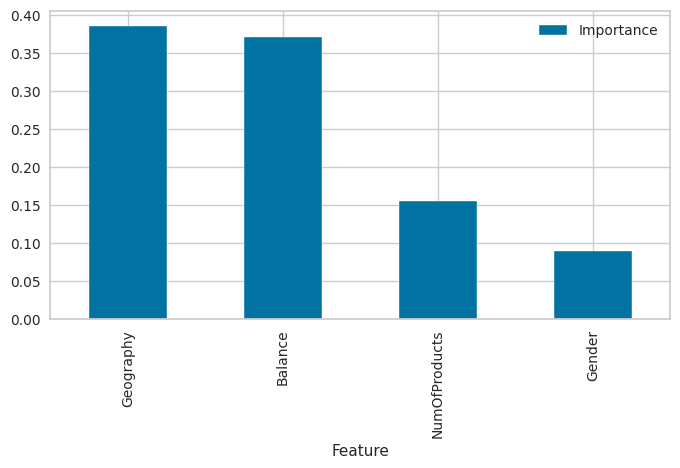

In [113]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [114]:
clusters_profile

,Geography,Balance,NumOfProducts,Gender,Exited
Cluster,,,,,
0,"'France': 69% , 'Spain': 31% , 'Germany': 0%",0.0 -- 0.0,2.0 -- 2.0,"'Female': 55% , 'Male': 45%","'0': 86% , '1': 14%"
1,"'France': 79% , 'Spain': 21%",86481.0 -- 138813.0,1.0 -- 1.0,"'Male': 72% , 'Female': 28%","'0': 82% , '1': 18%"
2,"'Germany': 79% , 'Spain': 21%",102689.0 -- 138651.0,1.0 -- 2.0,"'Female': 54% , 'Male': 46%","'0': 70% , '1': 30%"


In [115]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

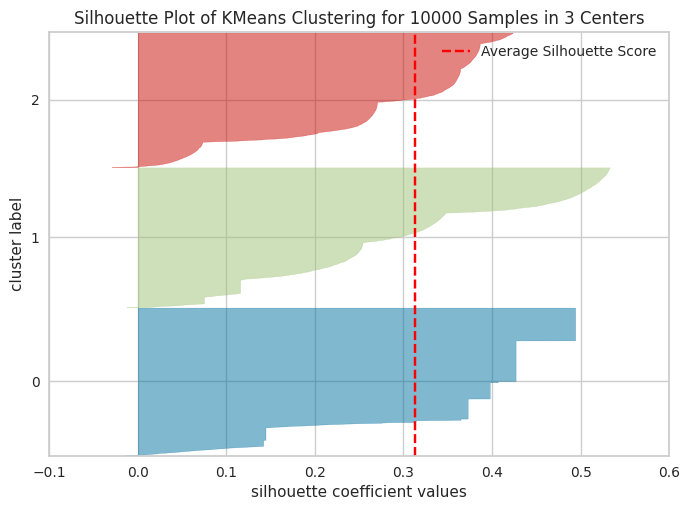

In [116]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

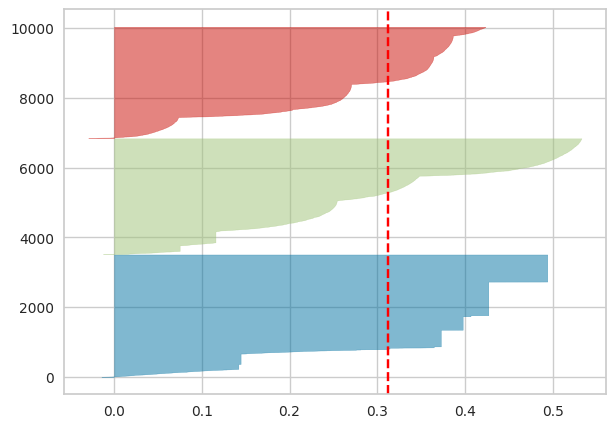

In [117]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell outputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!